# Content-Based

## 1. 장르별 평균으로 유저 프로필 만들기 

In [1]:
%matplotlib inline

import pandas as pd
pd.set_option('float_format', '{:f}'.format)

import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

In [2]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
genres = pd.read_pickle('genres.p')

In [3]:
movies.sample()

,movieId,title,genres
7685,89388,I Don't Know How She Does It (2011),Comedy


In [4]:
ratings.sample()

,userId,movieId,rating,timestamp
87388,563,7380,3.000000,1441845645


In [5]:
genres.sample()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
169,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [6]:
ratings = ratings.merge(genres, left_on='movieId', right_index=True).replace(0, np.nan)
ratings.sample()

,userId,movieId,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
23324,160,908,3.000000,971112529,nan,1.000000,1.000000,nan,nan,nan,...,nan,nan,nan,nan,1.000000,1.000000,nan,1.000000,nan,nan


In [7]:
train, test = train_test_split(ratings, test_size=.1, random_state=42)

### Item Profile

In [8]:
# 각 row가 영화 하나하나의 item profile
item_profile = genres.copy()

In [9]:
# 해리포터 시리즈의 movieId는?
movies[movies['title'].str.contains('Harry Potter')]

,movieId,title,genres
3574,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy
4076,5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy
5166,8368,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX
6062,40815,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller|IMAX
6522,54001,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy|IMAX
7078,69844,Harry Potter and the Half-Blood Prince (2009),Adventure|Fantasy|Mystery|Romance|IMAX
7465,81834,Harry Potter and the Deathly Hallows: Part 1 (...,Action|Adventure|Fantasy|IMAX
7644,88125,Harry Potter and the Deathly Hallows: Part 2 (...,Action|Adventure|Drama|Fantasy|Mystery|IMAX


In [10]:
# 해리포터와 마법사의 돌 movieId는 4896번
# 이 아이템의 프로필
item_profile.loc[4896]

(no genres listed)    0
Action                0
Adventure             1
Animation             0
Children              1
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               1
Film-Noir             0
Horror                0
IMAX                  0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Thriller              0
War                   0
Western               0
Name: 4896, dtype: int64

### 414번 유저 데이터

#### User Profile

In [11]:
genres_cols = item_profile.columns
genres_cols

Index(['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western'],
      dtype='object')

In [12]:
# 414번 유저의 데이터만 따로 떼어 테이블로 만든다.
user414_train = train[train['userId']==414]
user414_test = test[test['userId']==414]
user414_train.sample()

,userId,movieId,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
64938,414,143355,4.500000,1511535813,nan,1.000000,1.000000,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [13]:
# 모든 row(영화)마다 장르 값 1에 유저의 평점을 곱한다.
# 장르 값이 0인 것은 nan으로 바꿨으므로 계산에서 배제된다.
user414_train[genres_cols] = user414_train[genres_cols].apply(lambda x: x * user414_train['rating'])

In [14]:
user414_train.sample()

,userId,movieId,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
64138,414,6378,4.000000,1055778010,nan,4.000000,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [15]:
# 유저 프로필: 장르별 평점 평균
user414_profile = user414_train.groupby('userId')[genres_cols].mean()
user414_profile

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
414,4.250000,3.294599,3.440887,3.781818,3.381410,3.261634,3.484085,3.706897,3.553917,3.416256,3.857143,3.088710,3.721154,3.468421,3.589286,3.369565,3.397611,3.306338,3.859091,3.585106


#### Predict Test

#### Model Validation

### 전체 유저 데이터

#### User Profile

In [16]:
# 모든 row마다 장르 값(1) * 유저의 평점
for cols in genres_cols:
    train[cols] = train[cols] * train['rating']

In [17]:
train.sample()

,userId,movieId,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
583,6,36,5.000000,845553726,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [18]:
# 각 유저의 프로필: 본인의 장르별 평점 평균
user_profile = train.groupby('userId')[genres_cols].mean()
user_profile.sample()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
565,nan,3.125000,3.000000,3.000000,3.500000,3.166667,2.857143,nan,3.875000,3.000000,nan,nan,3.000000,3.000000,4.500000,3.714286,5.000000,3.600000,4.500000,nan


In [19]:
# 414번 유저의 유저 프로필
# 호러에 가장 낮은 평점을 줬다.
user_profile.loc[414].sort_values(ascending=False)

(no genres listed)   4.250000
War                  3.859091
Film-Noir            3.857143
Animation            3.781818
IMAX                 3.721154
Documentary          3.706897
Mystery              3.589286
Western              3.585106
Drama                3.553917
Crime                3.484085
Musical              3.468421
Adventure            3.440887
Fantasy              3.416256
Sci-Fi               3.397611
Children             3.381410
Romance              3.369565
Thriller             3.306338
Action               3.294599
Comedy               3.261634
Horror               3.088710
Name: 414, dtype: float64

In [20]:
# 414번이 평점 준 2439개 중에서 호러 장르가 포함된 영화는 124개 (train set 기준)
print(len(train[(train['userId']==414)]))
print(len(train[(train['userId']==414) & (train['Horror'].notnull())]))

2439
124


#### Predict Test

In [21]:
test['predict'] = np.nan

In [22]:
predict = []

# (유저 프로필 * 아이템 프로필)의 평균
for idx, row in test.iterrows():
    user = row['userId']
    predict.append((user_profile.loc[user] * row[genres_cols]).mean())

In [23]:
test['predict'] = predict
test.sample()

,userId,movieId,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,predict
21379,140,3257,3.000000,967049135,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,1.000000,nan,1.000000,nan,nan,3.537471


In [24]:
test.isnull().sum()

userId                    0
movieId                   0
rating                    0
timestamp                 0
(no genres listed)    10080
Action                 7102
Adventure              7705
Animation              9334
Children               9140
Comedy                 6081
Crime                  8414
Documentary            9944
Drama                  5985
Fantasy                8924
Film-Noir              9999
Horror                 9380
IMAX                   9697
Musical                9678
Mystery                9300
Romance                8205
Sci-Fi                 8383
Thriller               7482
War                    9582
Western                9900
predict                  17
dtype: int64

In [25]:
test[test['predict'].isnull()]

,userId,movieId,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,predict
43180,289,1258,4.000000,1143424663,nan,nan,nan,nan,nan,nan,...,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan
80861,510,556,4.000000,1141159618,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
65294,418,137337,4.000000,1461867778,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
36369,248,171011,3.500000,1534950954,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
84611,544,116,5.000000,850688776,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
61770,409,2064,5.000000,968979119,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
96017,602,246,3.000000,840876228,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
17249,110,7096,5.000000,1175330140,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
44460,296,169034,4.500000,1532994043,1.000000,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
22163,147,596,3.000000,1203267730,nan,nan,nan,1.000000,1.000000,nan,...,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,nan


In [26]:
movies[movies['movieId']==1258]

,movieId,title,genres
957,1258,"Shining, The (1980)",Horror


In [27]:
# Cold Start 문제:
# 평점을 예측할 영화의 장르에 대한 유저 프로필 값이 없는 경우, 예측이 되지 않는다.
# 1258번 영화는 아주 유명한 호러영화인 '샤이닝'(감독: 스탠리 큐브릭)인데 다른 장르 값은 없고 오직 호러 장르 값만 있다.
# 289번 유저는 호러 장르가 포함된 영화에 대해 평점을 준 적이 한 번도 없기 때문에 유저 프로필에서 호러에 대한 값이 nan이다. 
# 그러므로 샤이닝에 대한 289번 유저에 대한 평점은 예측할 수가 없다. 

# 이런 이유로 predict에 생긴 17개의 결측치를 train에 있는 평점의 전체 평균(global mean)으로 채워 넣어준다.
test.loc[test['predict'].isnull(), 'predict'] = train['rating'].mean()

#### Model Validation

In [28]:
mse = mean_squared_error(test['rating'], test['predict'])
rmse = np.sqrt(mse)
rmse

0.905133846685876

---
## 2. Linear Models로 유저 프로필 만들기

### Item Profile

In [29]:
item_profile = genres.copy()

### User Profile, Predict Test, Model Validation

#### 414번 유저 데이터 : Linear Regression 모델 사용

In [30]:
user414 = ratings[ratings['userId']==414].fillna(0)
user414.sample()

,userId,movieId,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
62375,414,176,4.000000,961438221,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
X_train, X_test, y_train, y_test = train_test_split(user414[genres_cols], user414['rating'], test_size=.1, random_state=42)

In [32]:
reg = LinearRegression()

In [33]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
reg.coef_

array([ 1.00892892, -0.2129349 ,  0.12201475,  0.64834251, -0.24301822,
       -0.08235458,  0.17050261,  0.37754937,  0.29124913,  0.05119872,
        0.33199616, -0.18713664,  0.36300092, -0.05888363,  0.1948136 ,
       -0.03130546,  0.14478509, -0.12231748,  0.46809841,  0.31149913])

In [35]:
# baseline 예상평점 
reg.intercept_

3.241071084255192

In [36]:
# Linear Regression(선형회귀) 간단 설명 필요

# 파이썬 버전에 따라 같은 random state를 써도 다르게 split 되는 듯. 
# 그래서 coef, intercept, rmse 등의 값이 다르게 나올 수 있다는 것 언급 해줘야 함.

In [37]:
list(zip(genres_cols, reg.coef_))

[('(no genres listed)', 1.0089289157448045),
 ('Action', -0.2129348989270317),
 ('Adventure', 0.1220147494097551),
 ('Animation', 0.6483425108153285),
 ('Children', -0.2430182203145799),
 ('Comedy', -0.08235457877204959),
 ('Crime', 0.17050261321221338),
 ('Documentary', 0.37754937259249505),
 ('Drama', 0.2912491327808548),
 ('Fantasy', 0.05119872389190665),
 ('Film-Noir', 0.33199616378201574),
 ('Horror', -0.18713663568417355),
 ('IMAX', 0.3630009190621155),
 ('Musical', -0.0588836334906063),
 ('Mystery', 0.19481360180048726),
 ('Romance', -0.03130545585484639),
 ('Sci-Fi', 0.14478508703759277),
 ('Thriller', -0.12231748387547858),
 ('War', 0.46809840605596187),
 ('Western', 0.3114991327834295)]

In [38]:
# 액션 장르 영화 예상평점
reg.intercept_ + reg.coef_[1]

3.0281361853281603

In [39]:
# 액션, 어드벤쳐 장르 동시에 있는 영화 예상평점
reg.intercept_ + reg.coef_[1] + reg.coef_[2]

3.1501509347379155

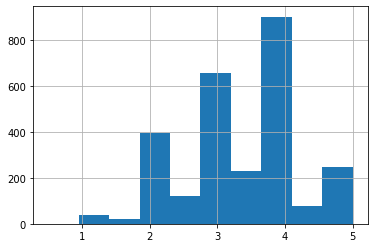

In [40]:
user414['rating'].hist()

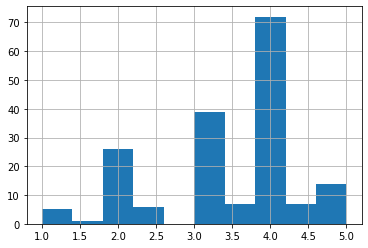

In [41]:
# 어린이 장르 평점 히스토그램
user414.loc[user414['Children']==1, 'rating'].hist()

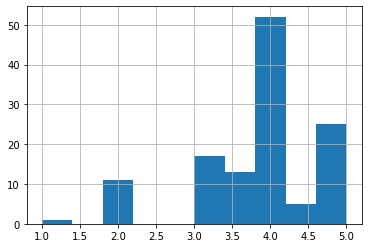

In [42]:
# 전쟁 장르 평점 히스토그램
user414.loc[user414['War']==1, 'rating'].hist()

In [43]:
# 아래는 앞에서 장르별 평균 평점으로 만든 유저414 프로필
# 높은 순으로 정렬해 봤을 때 linear regression으로 얻은 계수의 순서와 약간 차이가 있다.
# linear regression 버전에서는 가장 싫어하는 장르가 호러가 아니다.
user_profile.loc[414].sort_values(ascending=False)

(no genres listed)   4.250000
War                  3.859091
Film-Noir            3.857143
Animation            3.781818
IMAX                 3.721154
Documentary          3.706897
Mystery              3.589286
Western              3.585106
Drama                3.553917
Crime                3.484085
Musical              3.468421
Adventure            3.440887
Fantasy              3.416256
Sci-Fi               3.397611
Children             3.381410
Romance              3.369565
Thriller             3.306338
Action               3.294599
Comedy               3.261634
Horror               3.088710
Name: 414, dtype: float64

In [44]:
predict = reg.predict(X_test)

In [45]:
mse = mean_squared_error(y_test, predict)
rmse = np.sqrt(mse)
rmse

0.9185634946928368

#### 전체 데이터 : Linear Regression

In [46]:
train, test = train_test_split(ratings.fillna(0), test_size=.1, random_state=42)

In [47]:
user_profile_list = []

for userId in train['userId'].unique():
    user = train[train['userId'] == userId]
    X_train = user[genres_cols]
    y_train = user['rating']
    
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    user_profile_list.append([reg.intercept_, *reg.coef_])

In [48]:
user_profile = pd.DataFrame(user_profile_list, index=train['userId'].unique(), columns=['intercept', *genres_cols])
user_profile

,intercept,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
330,3.608521,0.000000,-0.059470,0.208439,0.433404,0.013092,-0.105517,0.166766,-0.000000,0.212886,...,-0.000000,0.590281,-0.095025,0.480033,0.294838,-0.096668,-0.303864,-0.146250,0.350173,0.628937
140,3.341252,0.000000,-0.034476,0.128389,-0.551057,0.257645,-0.225640,0.261084,0.158748,0.169254,...,0.154525,0.348029,0.757610,0.180253,-0.258412,0.238388,0.009138,-0.147291,0.246649,0.362129
610,3.639618,0.000000,-0.123126,0.119110,0.370285,-0.334279,0.037728,0.143155,0.475950,0.253962,...,0.587684,-0.098754,-0.036182,0.155432,0.111728,-0.074081,0.052001,-0.151253,0.001201,0.031538
603,3.581167,0.000000,-0.270141,-0.410447,-0.453376,0.113012,-0.296539,0.239802,0.373924,0.088388,...,0.522441,-0.092454,-0.000000,0.011448,-0.136682,-0.044535,-0.068835,0.096635,0.080587,0.503814
414,3.189313,1.060687,-0.161957,0.140164,0.652062,-0.300049,-0.073843,0.179078,0.481854,0.321749,...,0.289819,-0.166022,0.348867,0.053040,0.230769,-0.009888,0.168266,-0.113667,0.459609,0.329622
275,4.048501,0.000000,-0.222765,-0.018237,-0.287010,0.260987,-0.096096,0.297083,0.350741,0.037302,...,-0.349933,-0.688995,-0.000000,-0.035256,0.591598,0.004414,-0.282360,0.031954,0.501235,0.260777
210,3.715540,0.284460,0.004581,0.501443,0.241606,-0.177525,-0.222129,-0.512114,-0.000000,-0.145000,...,0.000000,-0.255822,0.155090,0.000000,0.604751,0.377958,0.257193,-0.392622,1.117973,0.000000
63,3.569388,0.000000,0.170357,-0.179813,1.017094,-0.475910,0.137062,0.137714,0.850958,-0.012915,...,0.568793,-0.668407,-0.180962,0.448153,0.260413,-0.284650,-0.123032,-0.161573,-0.127392,0.440068
417,4.128093,0.000000,-0.010367,-0.122734,-0.715490,0.323404,0.167323,0.003977,0.000000,0.362868,...,-0.000000,-0.427227,-0.535118,0.000000,0.090019,-0.054739,0.087078,0.222404,-0.032418,0.000000
19,2.371395,0.000000,0.180192,0.211700,0.233952,-0.119204,0.138019,0.302159,0.000000,0.049373,...,0.660341,-0.209813,0.017524,0.235259,0.588152,0.061697,0.008278,-0.131356,0.590775,-0.052967


In [49]:
# 평점 예측하기 1 : 유저프로필 이용해서 intercept + coef

predict = []

for idx, row in test.iterrows():
    user = row['userId']
    predict.append(sum(user_profile.loc[user, genres_cols] * row[genres.columns]) + user_profile.loc[user, 'intercept'])

In [50]:
test['predict'] = predict

In [51]:
mse = mean_squared_error(test['rating'], test['predict'])
rmse = np.sqrt(mse)
rmse

0.9801446829791878

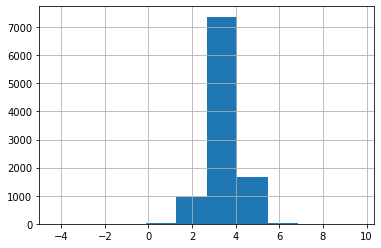

In [52]:
test['predict'].hist()

In [53]:
test.isnull().sum()

userId                0
movieId               0
rating                0
timestamp             0
(no genres listed)    0
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
IMAX                  0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Thriller              0
War                   0
Western               0
predict               0
dtype: int64

In [54]:
# 평점 예측하기 2 : sklearn의 fit 함수와 predict 함수를 연이어서
# 이게 더 쉬운 코드라고 생각했는데 막상 해 보니 1번이 더 간단하고 빠른 것 같긴 함..
# 2번의 장점은 뒤에서 reg = LinearRegression() 를 Lasso() 로만 바꾸면 된다는 점

for userId in test['userId'].unique():
    
    user_train = train[train['userId']==userId].set_index('movieId')
    X_train = user_train[genres.columns]
    y_train = user_train['rating'] 

    user_test = test[test['userId']==userId].set_index('movieId')
    X_test = user_test[genres.columns]

    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    y_predict = reg.predict(X_test)
    
    test.loc[test['userId']==userId, 'predict'] = y_predict

In [55]:
# 1번으로 했을 때랑 똑같은 RMSE

mse = mean_squared_error(test['rating'], test['predict'])
rmse = np.sqrt(mse)
rmse

0.9801446829791878

#### 전체 데이터 : Lasso

전체 데이터로 선형회귀를 돌려보니 414번 유저 데이터로만 했을 때보다 RMSE가 현저히 높아진다. (과적합 때문인가?) 평점을 20개 밖에 안 준 유저들처럼 피쳐 수(20개) 대비 데이터 수가 너무 적은 유저들이 있기 때문에 이런 결과가 나타난다.  
이럴 때, 정규화 회귀모델을 사용하면 좋다. 정규화의 핵심은 계수를 줄이는 것이다. 계수끼리 서로 값의 차이가 클 경우, 계수가 큰 변수가 예측값(여기서는 예상평점)에 훨씬 큰 영향을 미치게 된다. (데이터만으로는 각 장르의 중요도를 알 수도 없는데 영향력에 차이가 있음 안 되지 않을까? <- 맞는 설명인지 모르겠음)  
기존 회귀모델은 MSE를 최소화하는 방향으로 예측값을 찾는데, 정규화 회귀모델의 경우에는 MSE에 다른 값(추가 항)을 하나 더한 그 값을 최소화한다. 이 추가 항의 크기를 조절하는 것이 알파 값이다.  
정규화 모델 중에 가장 많이 쓰이는 것은 Ridge와 Lasso다. 라쏘는 변수 중에 중요한 것 몇 개만 선택하고, 나머지 변수의 계수는 0으로 줄여버린다. 릿지는 이와 다르게 완전히 0까지는 안 줄이고 0에 가까울 정도로 작은 수까지만 줄인다. 변수 간 상관관계 등을 이용해 직접 피쳐를 선택해 볼 수도 있겠지만, 라쏘 모델에 피팅을 시키면 이 모델이 피쳐를 알아서 골라준다.

In [56]:
from sklearn.linear_model import Lasso

In [57]:
for userId in test['userId'].unique():
    
    user_train = train[train['userId']==userId].set_index('movieId')
    X_train = user_train[genres.columns]
    y_train = user_train['rating'] 

    user_test = test[test['userId']==userId].set_index('movieId')
    X_test = user_test[genres.columns]
    
    # 이 코드에서 LinearRegression을 Lasso로만 바꾸면 됨 
    reg = Lasso(alpha=0.05)
    reg.fit(X_train, y_train)
    
    y_predict = reg.predict(X_test)
    
    test.loc[test['userId']==userId, 'predict'] = y_predict

In [58]:
# 알파 = 0.05 일 때

mse = mean_squared_error(test['rating'], test['predict'])
rmse = np.sqrt(mse)
rmse

0.9150790081817102

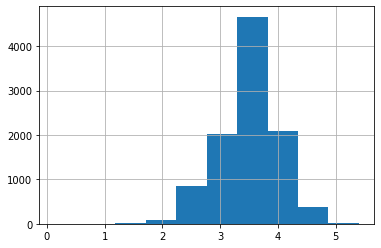

In [59]:
test['predict'].hist()

In [67]:
for userId in test['userId'].unique():
    
    user_train = train[train['userId']==userId].set_index('movieId')
    X_train = user_train[genres.columns]
    y_train = user_train['rating'] 

    user_test = test[test['userId']==userId].set_index('movieId')
    X_test = user_test[genres.columns]
    
    # 이 코드에서 LinearRegression을 Lasso로만 바꾸면 됨 
    reg = Lasso(alpha=0.04)
    reg.fit(X_train, y_train)
    
    y_predict = reg.predict(X_test)
    
    test.loc[test['userId']==userId, 'predict'] = y_predict

In [68]:
# 알파 = 0.04 일 때

mse = mean_squared_error(test['rating'], test['predict'])
rmse = np.sqrt(mse)
rmse

0.9140934761756713

In [70]:
for userId in test['userId'].unique():
    
    user_train = train[train['userId']==userId].set_index('movieId')
    X_train = user_train[genres.columns]
    y_train = user_train['rating'] 

    user_test = test[test['userId']==userId].set_index('movieId')
    X_test = user_test[genres.columns]
    
    # 이 코드에서 LinearRegression을 Lasso로만 바꾸면 됨 
    reg = Lasso(alpha=0.03)
    reg.fit(X_train, y_train)
    
    y_predict = reg.predict(X_test)
    
    test.loc[test['userId']==userId, 'predict'] = y_predict

In [71]:
# 알파 = 0.03 일 때

mse = mean_squared_error(test['rating'], test['predict'])
rmse = np.sqrt(mse)
rmse

0.9143586778975861

In [72]:
for userId in test['userId'].unique():
    
    user_train = train[train['userId']==userId].set_index('movieId')
    X_train = user_train[genres.columns]
    y_train = user_train['rating'] 

    user_test = test[test['userId']==userId].set_index('movieId')
    X_test = user_test[genres.columns]
    
    # 이 코드에서 LinearRegression을 Lasso로만 바꾸면 됨 
    reg = Lasso(alpha=0.035)
    reg.fit(X_train, y_train)
    
    y_predict = reg.predict(X_test)
    
    test.loc[test['userId']==userId, 'predict'] = y_predict

In [73]:
# 알파 = 0.035 일 때

mse = mean_squared_error(test['rating'], test['predict'])
rmse = np.sqrt(mse)
rmse

0.9139622742503078

In [74]:
for userId in test['userId'].unique():
    
    user_train = train[train['userId']==userId].set_index('movieId')
    X_train = user_train[genres.columns]
    y_train = user_train['rating'] 

    user_test = test[test['userId']==userId].set_index('movieId')
    X_test = user_test[genres.columns]
    
    # 이 코드에서 LinearRegression을 Lasso로만 바꾸면 됨 
    reg = Lasso(alpha=0.037)
    reg.fit(X_train, y_train)
    
    y_predict = reg.predict(X_test)
    
    test.loc[test['userId']==userId, 'predict'] = y_predict

In [75]:
# 알파 = 0.037 일 때

mse = mean_squared_error(test['rating'], test['predict'])
rmse = np.sqrt(mse)
rmse

0.9139524538401915

In [76]:
for userId in test['userId'].unique():
    
    user_train = train[train['userId']==userId].set_index('movieId')
    X_train = user_train[genres.columns]
    y_train = user_train['rating'] 

    user_test = test[test['userId']==userId].set_index('movieId')
    X_test = user_test[genres.columns]
    
    # 이 코드에서 LinearRegression을 Lasso로만 바꾸면 됨 
    reg = Lasso(alpha=0.038)
    reg.fit(X_train, y_train)
    
    y_predict = reg.predict(X_test)
    
    test.loc[test['userId']==userId, 'predict'] = y_predict

In [77]:
# 알파 = 0.038 일 때

mse = mean_squared_error(test['rating'], test['predict'])
rmse = np.sqrt(mse)
rmse

0.913987772504372

In [78]:
for userId in test['userId'].unique():
    
    user_train = train[train['userId']==userId].set_index('movieId')
    X_train = user_train[genres.columns]
    y_train = user_train['rating'] 

    user_test = test[test['userId']==userId].set_index('movieId')
    X_test = user_test[genres.columns]
    
    # 이 코드에서 LinearRegression을 Lasso로만 바꾸면 됨 
    reg = Lasso(alpha=0.036)
    reg.fit(X_train, y_train)
    
    y_predict = reg.predict(X_test)
    
    test.loc[test['userId']==userId, 'predict'] = y_predict

In [79]:
# 알파 = 0.036 일 때

mse = mean_squared_error(test['rating'], test['predict'])
rmse = np.sqrt(mse)
rmse

0.913940501243069

In [63]:
param_grid = {'alpha': uniform(0,1)}

model = Lasso()
rand_search = RandomizedSearchCV(estimator=model, 
                                 param_distributions=param_grid,
                                 n_iter=100,
                                 cv=10)

rand_search.fit(ratings[genres_cols], ratings['rating'])

print(rand_search.best_estimator_.alpha)
print(rand_search.best_score_)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').